In [1]:
import os
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

data_path = os.getcwd() + '/Data/'
logs_path = os.getcwd() + '/Logs/'

data = pd.read_csv(data_path + 'vni30.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data['date'] = data['date'].astype('datetime64')
data = data.set_index(['date'])
data = data.sort_values(['date'])

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

def experiment_predict(training_data, testing_data, order=(5,1,0)):
    history_data = list(training_data)
    predictions = list()
    for t in tqdm(range(len(testing_data)+1)):
        model = ARIMA(history_data, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        predictions.append(output[0][0])
        if t < len(testing_data):
            obs = testing_data[t]
            history_data.append(obs)
    return predictions

def evaluation(validation):
    mse = mean_squared_error(validation['ground_true'], validation['prediction'])
    rmse = root_mean_squared_error(validation['ground_true'], validation['prediction'])
    mae = mean_absolute_error(validation['ground_true'], validation['prediction'])
    mape = mean_absolute_percentage_error(validation['ground_true'], validation['prediction'])
    return mse, rmse, mae, mape

def experiment_logs(experiment_results):
    with open(logs_path + 'experiment_logs.txt', 'a') as fout:
        json.dump(experiment_results, fout)
        
def gen_params():
    q = range(1, 6)
    d = range(1, 2)
    p = range(0, 2)
    return list(itertools.product(q, d, p))

In [9]:
def run_experiment(data, start_train=0.6, end_train=0.95):
    # Split data
    size = len(data)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = data[train_start:train_end], data[train_end:]
    
    # Generate parameters
    params = gen_params()

    # Run experiments
    result_lst = []
    for param in params:
        try:
            result = {'pdq': param}

            # Prediction
            predictions = experiment_predict(train['price'].values, test['price'].values, order=param)

            # Evaluation
            validation = pd.DataFrame()
            validation['ground_true'] = test['price']
            validation['prediction'] = predictions[1:]
            mse, rmse, mae, mape = evaluation(validation)
            result['mse'] = mse
            result['rmse'] = rmse
            result['mae'] = mae
            result['mape'] = mape
            result_lst.append(result)
        except:
            continue
    
    # Record experiment results
#     experiment_logs(result_lst)
    return result_lst

## Daily data

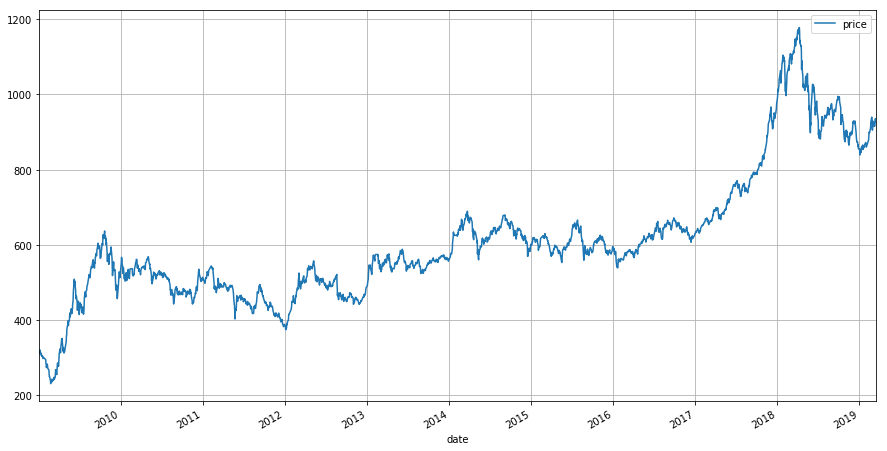

In [10]:
data.plot(figsize=(15,8), grid=True)
plt.show()

In [11]:
result_lst = run_experiment(data)
df_result = pd.DataFrame(result_lst)
df_result.head(10)

100%|██████████| 129/129 [00:49<00:00,  2.11it/s]


""


## Weekly data

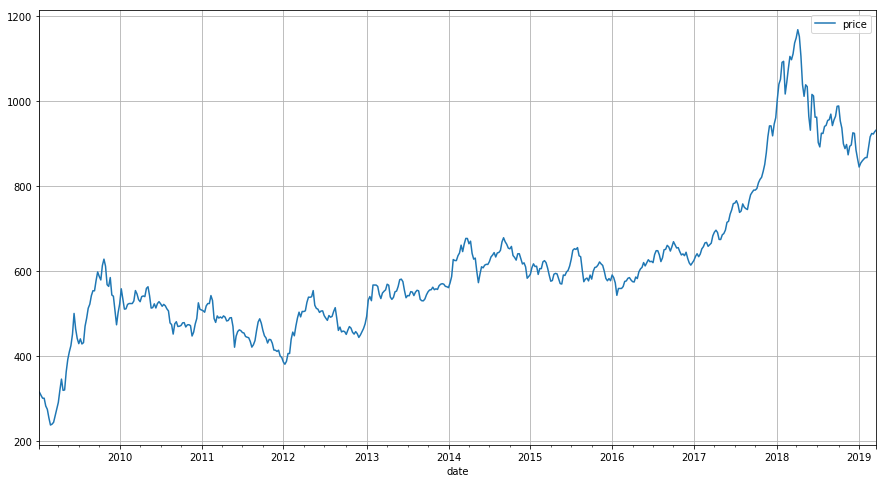

In [6]:
weekly_data = data.resample('W').mean().fillna(method='ffill')
weekly_data.plot(figsize=(15,8),  grid=True)
plt.show()

In [7]:
result_lst = run_experiment(weekly_data,  start_train=0.3, end_train=0.95)
df_result = pd.DataFrame(result_lst)
df_result.head(10)

 50%|█████     | 14/28 [00:03<00:03,  4.03it/s]/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()

100%|██████████| 28/28 [00:07<00:00,  3.59it

,mae,mape,mse,param
0,3.380955,0.372766,15.374938,"(1, 1, 0)"
1,3.941295,0.433594,24.724465,"(1, 1, 1)"
2,3.506800,0.387153,19.147109,"(2, 1, 0)"
3,4.032932,0.443833,24.924448,"(2, 1, 1)"
4,3.940138,0.435326,23.297081,"(3, 1, 0)"
5,3.999623,0.440404,25.158790,"(3, 1, 1)"
6,4.070061,0.449681,25.526915,"(4, 1, 0)"
7,4.222816,0.464749,26.640127,"(5, 1, 0)"
8,4.269992,0.470457,27.012338,"(5, 1, 1)"


## Return of daily data

In [8]:
daily_return = data['price'].diff()
df_daily_return = pd.DataFrame(index=data.index)
df_daily_return['return'] = daily_return
df_daily_return['prev_price'] = data['price'].shift(periods=1)
df_daily_return['curr_price'] = data['price']
df_daily_return.head()

,return,prev_price,curr_price
date,,,
2009-01-05,NaN,NaN,311.23
2009-01-06,2.98,311.23,314.21
2009-01-07,6.32,314.21,320.53
2009-01-08,-6.39,320.53,314.14
2009-01-09,-1.24,314.14,312.90


In [9]:
def predict_return(training_data, testing_data, order=(5,1,0)):
    history_data = list(training_data['return'][1:])
    predictions = list()
    for t in tqdm(range(len(testing_data))):
        model = ARIMA(history_data, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        predicted_return = output[0][0]
        predicted_price = testing_data['prev_price'][t] + predicted_return
        predictions.append(predicted_price)
        
        obs = testing_data['return'][t]
        history_data.append(obs)
    return predictions

def run_experiment_return(data, start_train=0.6, end_train=0.95):
    # Split data
    size = len(data)
    # Split data
    size = len(data)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = data[train_start:train_end], data[train_end:]
    
    # Generate parameters
    params = gen_params()

    # Run experiments
    result_lst = []
    for param in params:
        try:
            result = {'param': param}

            # Prediction
            predictions = predict_return(train, test, order=param)

            # Evaluation
            validation = pd.DataFrame()
            validation['ground_true'] = test['curr_price']
            validation['prediction'] = predictions
            mse, mae, mape = evaluation(validation)
            result['mse'] = mse
            result['mae'] = mae
            result['mape'] = mape
            result_lst.append(result)
        except:
            continue
    
    # Record experiment results
#     experiment_logs(result_lst)
    return result_lst

In [10]:
result_lst = run_experiment_return(df_daily_return,  start_train=0.6, end_train=0.95)
df_result = pd.DataFrame(result_lst)
df_result.head(10)

 55%|█████▍    | 70/128 [00:53<00:40,  1.45it/s]/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 65%|██████▍   | 83/128 [01:20<00:57,  1.28s/it]/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))

,mae,mape,mse,param
0,8.190747,0.901093,127.194423,"(1, 1, 0)"
1,7.040811,0.775933,95.628061,"(1, 1, 1)"
2,7.852665,0.863381,114.382488,"(2, 1, 0)"
3,6.948437,0.765267,92.831955,"(2, 1, 1)"
4,7.705074,0.847930,114.117485,"(3, 1, 0)"
5,6.924535,0.762426,92.564530,"(3, 1, 1)"
6,7.536330,0.829652,112.055151,"(4, 1, 0)"
7,7.391918,0.813506,110.058023,"(5, 1, 0)"
8,6.990364,0.769267,94.395638,"(5, 1, 1)"


## Return of weekly data

In [11]:
weekly_return = weekly_data.diff()
df_weekly_return = pd.DataFrame(index=weekly_data.index)
df_weekly_return['return'] = weekly_return
df_weekly_return['prev_price'] = weekly_data['price'].shift(periods=1)
df_weekly_return['curr_price'] = weekly_data['price']
df_weekly_return.head()

,return,prev_price,curr_price
date,,,
2009-01-11,NaN,NaN,314.602
2009-01-18,-7.390,314.602,307.212
2009-01-25,-6.756,307.212,300.456
2009-02-01,0.000,300.456,300.456
2009-02-08,-18.310,300.456,282.146


In [12]:
result_lst = run_experiment_return(df_weekly_return,  start_train=0.3, end_train=0.95)
df_result = pd.DataFrame(result_lst)
df_result.head(10)


 52%|█████▏    | 14/27 [00:01<00:00, 13.22it/s]/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

100%|██████████| 27/27 [00:17<00:00,  1.61it/s]

,mae,mape,mse,param
0,15.888920,1.753309,411.395227,"(1, 1, 0)"
1,17.668912,1.947915,476.162375,"(2, 1, 0)"
2,13.627309,1.507222,335.612355,"(2, 1, 1)"
3,17.455189,1.933322,466.730371,"(3, 1, 0)"
4,14.281517,1.577925,353.765680,"(3, 1, 1)"
5,16.471298,1.818793,408.082232,"(4, 1, 0)"
6,14.258602,1.574111,352.754747,"(4, 1, 1)"
7,16.315219,1.805037,435.155793,"(5, 1, 0)"
8,14.314668,1.579730,348.185831,"(5, 1, 1)"
